In [796]:
include("load_data_dependencies.jl")

┌ Warning: Duplicated knots were deduplicated. Use Interpolations.deduplicate_knots!(knots) explicitly to avoid this warning.
│   k1 =
│    14-element Vector{Float64}:
│     0.0
│     0.022959230401096927
│     0.04405845113136857
│     0.07084030195235157
│     0.11232953691495227
│     ⋮
│     0.754237672954132
│     0.9555284363399403
│     0.9989955251533423
│     1.0000000000000002
│     1.0000000000000002
└ @ Interpolations ~/.julia/packages/Interpolations/y4lLj/src/gridded/gridded.jl:77
┌ Warning: Duplicated knots were deduplicated. Use Interpolations.deduplicate_knots!(knots) explicitly to avoid this warning.
│   k1 =
│    15-element Vector{Float64}:
│     0.0
│     0.01947902682360647
│     0.0347242344133679
│     0.052785424819226066
│     0.09628136901295029
│     ⋮
│     0.7636614965974512
│     0.9723872952746974
│     0.999460162748707
│     1.0
│     1.0
└ @ Interpolations ~/.julia/packages/Interpolations/y4lLj/src/gridded/gridded.jl:77
┌ Warning: Duplicated knots were 

In [1078]:
using MCLLH

In [1079]:
LLHeff(1, 1, 1)

-1.3862943611198904

In [837]:
# Cut all neutrinos outside our energy smearing energy bounds

ecut = energy_cut(rs0, ls0, bs0, rws0, us0, oneweights0, umin=log10(5e-1), umax=log10(4e3))
rs, ls, bs, rws, us, oneweights = ecut[:,1], ecut[:,2], ecut[:,3], ecut[:,4], ecut[:,5], ecut[:,6]

# rcut = r_cut(rs1, ls1, bs1, rws1, us1, oneweights1, rmin=0.3)
# rs, ls, bs, rws, us, oneweights = rcut[:,1], rcut[:,2], rcut[:,3], rcut[:,4], rcut[:,5], rcut[:,6]

# Smear the log energy Monte Carlo
us_sm = smearuMC(us, esmearvec)

# Smear in angle
ls_sm, bs_sm = angsmearMC(ls, bs);

In [838]:
old_ws = Weights(ones(length(rs)))

r_weights = Weights(rws ./ (rs .^ 2))

ews = Weights(old_ws .* power_law_flux.(10 .^ us, 2.4-1))

aws = effarea.(10 .^ us) * 10000

oscws_null = oscprob.(10 .^ us, 0, rs)

dm2 = 10^(-13.8)
dm2 = ones(length(rs)) .* dm2
oscws = oscprob.(10 .^ us, dm2, rs)

;

In [873]:
maximum(bs)

1.5386667729680543

In [1081]:
rbs, lbs, bbs = 0:0.1:20, -π:π/25:π, -π/2:π/25:π/2

rlbs = Distributions.fit(Histogram, (rs, ls, bs), r_weights, (rbs, lbs, bbs)).weights

rlbs_unw = Distributions.fit(Histogram, (rs, ls, bs), r_weights, (rbs, lbs, bbs)).weights;

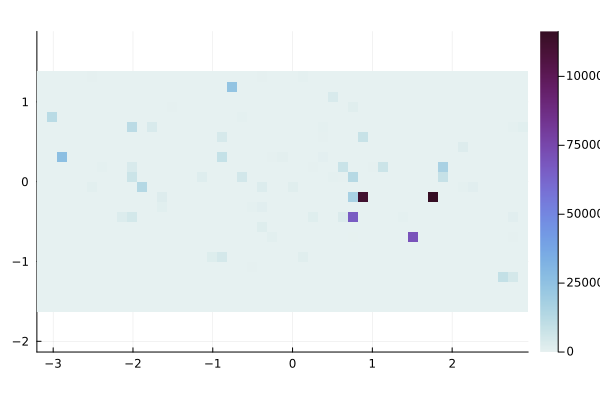

In [1080]:
#=
anim = @animate for i in 1:10
    logerange = range(log10(emin), log10(emax), 49)
    ls = range(-π, π, length=49)
    l = round(ls[i], digits=3)
    gamma_params = linear_fit(logerange, log10.(es_vs_ls[:, i]))
    gammafunc(x) = gamma_params[1] + x*gamma_params[2]
    plot(logerange,
        log10.(es_vs_ls[:, i]),
        seriestype=:step,
        label=false,
        clims=(0, maximum(log10.(es_vs_ls))),
        title="l = $l"
    )
    plot!(logerange, gammafunc.(logerange), label=false)
end

gif(anim, "logE_by_l_cut_me23.gif", fps=3)
=#

heatmap(
    lbs[1:end-1],
    bbs[1:end-1],
    transpose(rlbs[1, :, :]),
    aspect_ratio=1,
    # clims=(0, maximum(rlbs)),
    c=:dense
)

In [1003]:
bindist = range(0, maximum(rlbs), 100)

bins = Distributions.fit(Histogram, (vec(rlbs[15, :, :])), bindist).weights

99-element Vector{Int64}:
 1131
   28
   13
    3
    1
    0
    0
    0
    0
    0
    0
    0
    0
    ⋮
    0
    0
    0
    0
    0
    0
    0
    0
    0
    0
    0
    0

In [998]:
function binspread(i)

    bins = Distributions.fit(Histogram, (vec(rlbs[i, :, :])), bindist).weights

    max_val_index = argmax([bindist[1:end-1][j] * (bins[j] != 0) for j in 1:length(bindist)-1])

    max_nonzero_bin = bindist[max_val_index]

    return (max_nonzero_bin - mean(bindist[1:end-1], Weights(bins[1:end]))) / std(bindist[1:end-1], Weights(bins[1:end]))
end

binspreads = [binspread(i) for i in 1:50]

50-element Vector{Float64}:
 24.43032529576409
 14.987270683372646
 21.47640428297013
 19.51512697622948
 16.633677878212097
 12.78313938340469
 11.300005247308636
 12.528443652274996
 13.708578945078568
 12.951445138501324
 16.988456670439305
 11.149666743591517
  9.117099324584128
  ⋮
 14.834770727423168
 14.110821251787206
 16.469622284337028
 11.900449136699525
 10.80237530476525
 11.557962860689747
 12.710466134925525
 14.274205509767866
 13.173276405951773
 13.69064503568639
 13.973292497683088
 13.973292497683088

In [1066]:
function maxprominence(i, spotsize)

    rslice = rlbs[i, :, :]

    lmax, bmax = Tuple(argmax(rslice))

    if lmax == 1
        return rslice[lmax, bmax] / sum(rslice[lmax:lmax+spotsize, bmax-spotsize:bmax+spotsize])
    elseif lmax == 49 
        return rslice[lmax, bmax] / sum(rslice[lmax-spotsize:lmax, bmax-spotsize:bmax+spotsize])
    else
        return rslice[lmax, bmax] / sum(rslice[lmax-spotsize:lmax+spotsize, bmax-spotsize:bmax+spotsize])
    end
end

maxprominence (generic function with 2 methods)

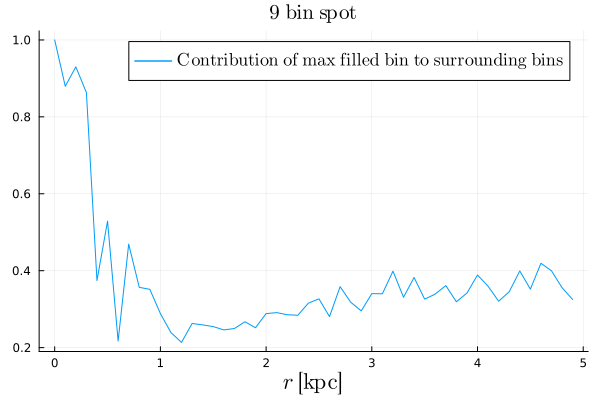

In [1076]:
maxprominences = [maxprominence(i, 1) for i in 1:50]

plot(
    rbs[1:50],
    maxprominences,
    xlabel=L"r~\mathrm{[kpc]}",
    label=L"\mathrm{Contribution~of~max~filled~bin~to~surrounding~bins}",
    title=L"\mathrm{9~bin~spot}",
    legendfontsize=12,
    xguidefontsize=15,
    yguidefontsize=15
)

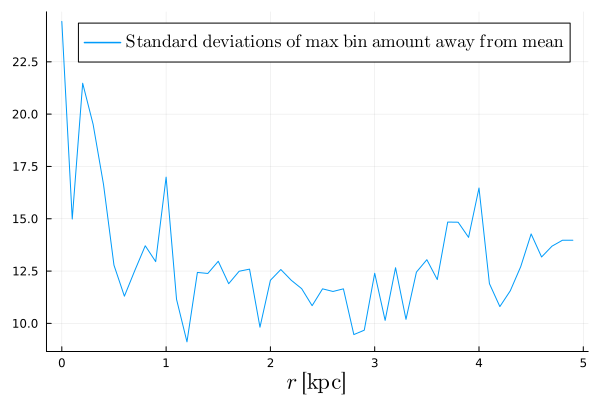

In [1018]:
plot(
    rbs[1:50],
    binspreads,
    xlabel=L"r~\mathrm{[kpc]}",
    label=L"\mathrm{Standard~deviations~of~max~bin~amount~away~from~mean}",
    legendfontsize=12,
    xguidefontsize=15,
    yguidefontsize=15
)

In [1014]:
function binmaxshare(i)
    return maximum(rlbs[i, :, :]) / sum(rlbs[i, :, :])
end

binmaxshares = [binmaxshare(i) for i in 1:50];

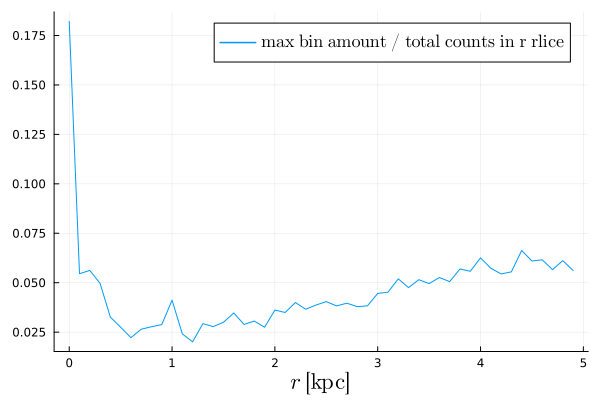

In [1021]:
plot(
    rbs[1:50],
    binmaxshares,
    xlabel=L"r~\mathrm{[kpc]}",
    label=L"\mathrm{max~bin~amount~/~total~counts~in~r~rlice}",
    legendfontsize=12,
    xguidefontsize=15,
    yguidefontsize=15
)

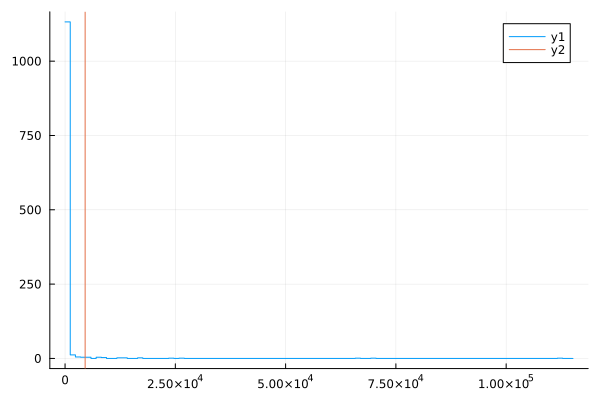

In [979]:
plot(
    bindist[1:end-1],
    bins[1:end],
    seriestype=:step
)

plot!(
    log10.(bindist[1:end-1]),
    [std(bindist[1:end-1], Weights(bins[1:end]))],
    seriestype=:vline,
)

#=
plot!(
    bindist[2:end-1],
    [median(bindist[2:end-1], Weights(bins[2:end]))],
    seriestype=:vline,
)
=#

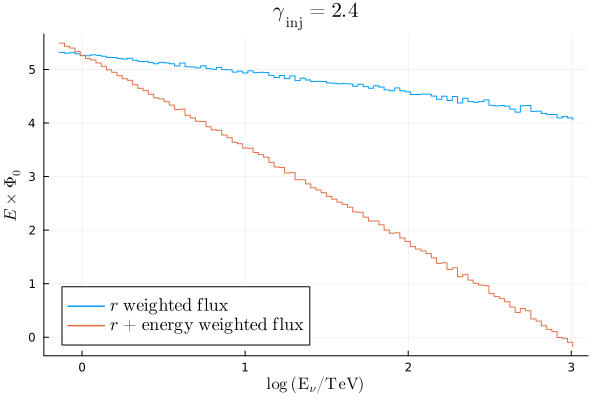

In [802]:
us_b = Distributions.fit(Histogram, us, r_weights, range(log10(emin), log10(emax), 100))
us_bw = Distributions.fit(Histogram, us, Weights(ews .* r_weights), range(log10(emin), log10(emax), 100))
plot(
    range(log10(emin), log10(emax), 100)[1:end-1], 
    [log10.(us_b.weights) log10.(us_bw.weights)], 
    seriestype=:step,
    label=[L"r\mathrm{~weighted~flux}" L"r+\mathrm{energy~weighted~flux}"],
    ylabel=L"E\times\Phi_0",
    xlabel=L"\mathrm{\log~(E_\nu/\mathrm{TeV})}",
    title=L"\gamma_\mathrm{inj} = 2.4",
    legendfontsize=12
)

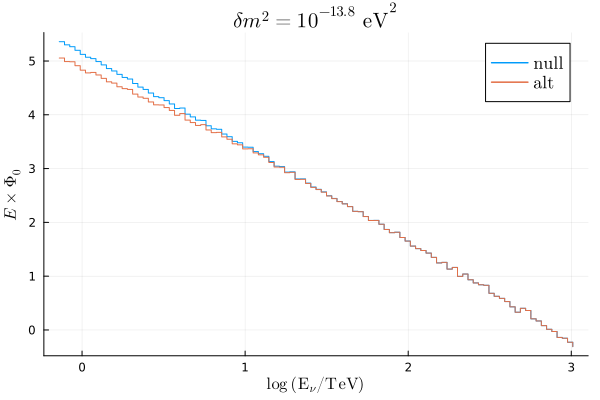

In [803]:
binned_new_us = Distributions.fit(Histogram, us, Weights(r_weights .* ews .* oscws_null), range(log10(emin), log10(emax), 100))
binned_nnew_us = Distributions.fit(Histogram, us, Weights(r_weights .* ews .* oscws), range(log10(emin), log10(emax), 100))
plot(
    range(log10(emin), log10(emax), 100)[1:end-1], 
    [log10.(binned_new_us.weights) log10.(binned_nnew_us.weights)], 
    seriestype=:step,
    label=[L"\mathrm{null}" L"\mathrm{alt}"],
    ylabel=L"E \times \Phi_0",
    xlabel=L"\mathrm{\log~(E_\nu/\mathrm{TeV})}",
    title=L"\delta m^2 = 10^{-13.8}~\mathrm{eV}^2",
    legendfontsize=12
)

In [804]:
function weights_errs(binned_var, weights_vec, edges)

    binned = Distributions.fit(Histogram, binned_var, Weights(weights_vec), edges).weights
    b_err = Distributions.fit(Histogram, binned_var, Weights(weights_vec .^ 2), edges).weights
    errs = sqrt.(b_err)

    return binned, errs

end

weights_errs (generic function with 1 method)

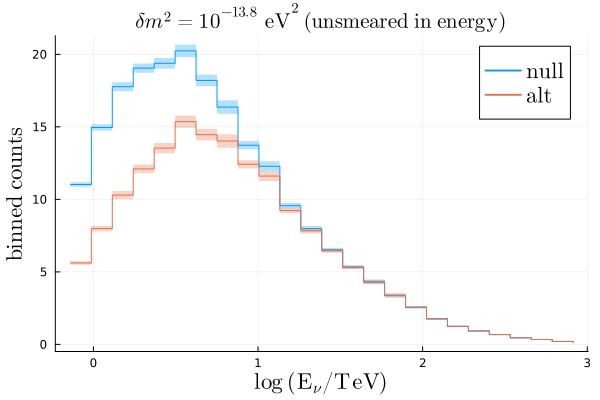

In [805]:
numubins = 26
usbins = range(log10(emin), log10(emax), numubins)
basews = r_weights .* ews .* aws

us_b, errs_b = weights_errs(us, basews .* oscws_null, usbins)
us_b_alt, errs_b_alt = weights_errs(us, basews .* oscws, usbins)
us_b_sm, errs_b_sm = weights_errs(us_sm, basews .* oscws_null, usbins)
us_b_sm_alt, errs_b_sm_alt = weights_errs(us_sm, basews .* oscws, usbins)

Φ₀ = 2.729118862398479e-8

plot(
    usbins[1:end-1], 
    [Φ₀*us_b Φ₀*us_b_alt], 
    ribbon=[Φ₀*errs_b Φ₀*errs_b_alt],
    fillalpha=0.3,
    seriestype=:step,
    label=[L"\mathrm{null}" L"\mathrm{alt}"],
    ylabel=L"\mathrm{binned~counts}",  
    xlabel=L"\mathrm{\log~(E_\nu/\mathrm{TeV})}",
    title=L"\delta m^2 = 10^{-13.8}~\mathrm{eV}^2~\mathrm{(unsmeared~in~energy)}",
    legendfontsize=15,
    xguidefontsize=15,
    yguidefontsize=15
)

In [806]:
function weighthist_es(rs, ls, bs, us, us_sm, weights; smear=false, rbinsize=0.1, θbinsize=π/25, minloge=log10(emin), maxloge=log10(emax), elength=26)

    # We take square angular bins
    lbins, bbins, logebins = -π:θbinsize:π, -π/2:θbinsize:π/2, range(minloge, maxloge, length=elength)

    ϕ₀ = 2.729118862398479e-8

    if smear
        binnedu = us_sm
    else
        binnedu = us
    end

    nuws, nuerrs = weights_errs((ls, bs, binnedu), weights, (lbins, bbins, logebins))
    #=
    nuhist = StatsBase.fit(Histogram, (ls, bs, us), weights, (lbins, bbins, logebins), closed=:left)
    nuws = Φ₀ * nuhist.weights

    err = StatsBase.fit(Histogram, (ls, bs, us), Weights(weights .^ 2), (lbins, bbins, logebins), closed=:left)
    errws = Φ₀ * sqrt.(err.weights)
    =#

    return ϕ₀*nuws, ϕ₀*nuerrs

end

weighthist_es (generic function with 1 method)

In [807]:
ws = Weights(r_weights .* ews .* oscws_null .* aws)
ws_alt = Weights(r_weights .* ews .* oscws .* aws)

nullws, nullerrs = weighthist_es(rs, ls_sm, bs_sm, us, us_sm, ws, θbinsize=π/25, elength=26)
altws, alterrs = weighthist_es(rs, ls_sm, bs_sm, us, us_sm, ws_alt, θbinsize=π/25, elength=26)

nullws_sm, nullerrs_sm = weighthist_es(rs, ls_sm, bs_sm, us, us_sm, ws, smear=true, θbinsize=π/25, elength=26)
altws_sm, alterrs_sm = weighthist_es(rs, ls_sm, bs_sm, us, us_sm, ws_alt, smear=true, θbinsize=π/25, elength=26)
;

In [811]:
l = 25
b = 13

13

In [813]:
nullbin = nullws[l, b, :]
nullerrbin = nullerrs[l, b, :]

altbin = altws[l, b, :]
alterrbin = alterrs[l, b, :]

nullbin_sm = nullws_sm[l, b, :]
nullerrbin_sm = nullerrs_sm[l, b, :]

altbin_sm = altws_sm[l, b, :]
alterrbin_sm = alterrs_sm[l, b, :]
;

In [662]:
#=
function matrix_errprop(mat, errvec)

    len = length(errvec)

    properrvec = zeros(len)

    for i in 1:len
        vec = [(mat[i, j] * nullerrbin[j])^2 for j in 1:len]
        properrvec[i] = sqrt(sum(vec))
    end

    return properrvec

end

emat = eresbinned

nullbin = emat * nullws[l, b, :]
nullerrbin_prop = matrix_errprop(emat, nullerrs[l, b, :])

altbin = emat * altws[l, b, :]
alterrbin_prop = matrix_errprop(emat, alterrs[l, b, :]);
=#

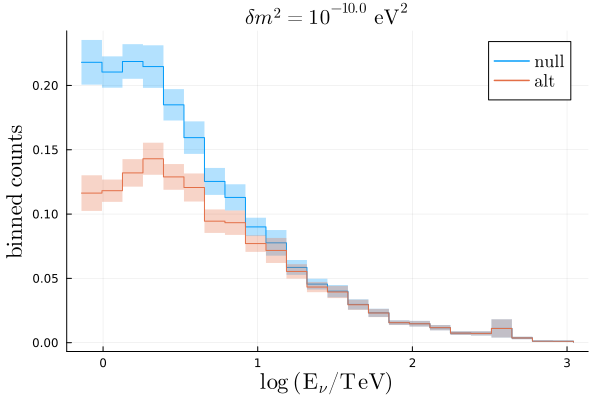

In [814]:
plot(
    range(log10(emin), log10(emax), 25),
    [nullbin_sm altbin_sm], 
    ribbon=[nullerrbin_sm alterrbin_sm],
    fillalpha=0.3,
    seriestype=:step,
    label=[L"\mathrm{null}" L"\mathrm{alt}"],
    ylabel=L"\mathrm{binned~counts}",
    xlabel=L"\mathrm{\log~(E_\nu/\mathrm{TeV})}",
    # title=L"\delta m^2 = 10^{-13.8}~\mathrm{eV}^2,~7^\circ~\mathrm{degree~bin}"
    title=L"\delta m^2 = 10^{-10.0}~\mathrm{eV^2}",
    legendfontsize=12,
    xguidefontsize=15,
    yguidefontsize=15
    )
#=
plot!(
    range(log10(emin), log10(emax), 25),
    2*altbin_sm,
    linestyle=:dash,
    lw=2,
    seriestype=:step,
    label=L"2\times\mathrm{alt}",
    legendfontsize=12,
)
=#

In [815]:
old_ws = Weights(ones(length(rs)))

r_weights = Weights(rws ./ (rs .^ 2))

ews = Weights(old_ws .* power_law_flux.(10 .^ us, 2.4-1))

aws = effarea.(10 .^ us) * 10000

oscws_null = oscprob.(10 .^ us, 0, rs)

dm2 = 10^(-13.8)
dm2 = ones(length(rs)) .* dm2
oscws = oscprob.(10 .^ us, dm2, rs)
;

In [816]:
function base_weights(γ_inj, rs, rws, us)

    old_ws = Weights(ones(length(rs)))
    r_weights = Weights(rws ./ (rs .^ 2))
    ews = Weights(old_ws .* power_law_flux.(10 .^ us, γ_inj - 1))
    aws = effarea.(10 .^ us) * 10000

    return r_weights .* ews .* aws

end

basews = base_weights(2.4, rs, rws, us)

oscws_null = oscprob.(10 .^ us, 0, rs)

nullws = basews .* oscws_null

nullws_sm, nullerrs_sm = weighthist_es(rs, ls_sm, bs_sm, us, us_sm, nullws, smear=true, θbinsize=π/25, elength=26)

function binnededists(δm²; rs=rs, ls=ls, bs=bs, us=us, us_sm=us_sm, bws=basews, ϕ₀=1)

    oscws_alt = oscprob.(10 .^ us, δm², rs)

    ws = bws .* oscws_alt

    nullws, nullerrs = ϕ₀ .* weighthist_es(rs, ls, bs, us, us_sm, ws, smear=true)

    return nullws, nullerrs

end

binnededists (generic function with 2 methods)

In [817]:
nulldists = binnededists(0)[1];

In [818]:
altdists = binnededists(10^(-13.7))[1];

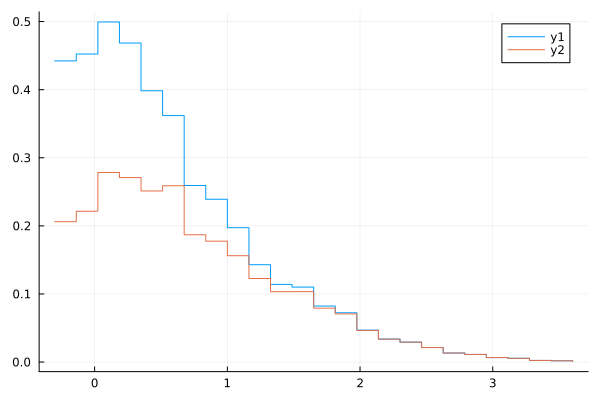

In [819]:
plot(loges25,
    [nulldists[25, 13, :] altdists[25, 13, :]],
    seriestype=:step
)

In [832]:
function param_optimizer(δm²; nulldists=nulldists)

    function negloglh(δm², norm)
        altdists = binnededists(δm²; ϕ₀=norm)[1]

        sumllh = 0

        for i in 1:24
            for j in 1:49
                altsummand = poissonlog.(nulldists[j, i, :], altdists[j, i, :])
                sumllh += -sum(altsummand)
            end
        end
        return sumllh
    end

    function maxloglh_params(δm²)

        function nllh(test)
            return negloglh(δm², test[1])
        end
    
        x0 = [1.0]
    
        optimized = optimize(nllh, x0, NelderMead())

        asmaxparams = Optim.minimizer(optimized)
    
    end

    return maxloglh_params(δm²)

end

function asts(δm²; nulldists=nulldists)
    maxparams = param_optimizer(δm²)
    allsky_edists_alt = binnededists(δm²; ϕ₀=maxparams[1])[1]
    # tscontributions = [lrt(nulldists[i, j, :], allsky_edists_alt[i, j, :]) for j in 1:24, i in 1:49]
end;

In [725]:
function negloglh(δm², norm)
    altdists = binnededists(δm²; ϕ₀=norm)[1]

    sumllh = 0

    for i in 1:24
        for j in 1:49
            null, alt = nulldists[j, i, :], altdists[j, i, :]
            altsummand = poissonlog.(null, alt)
            sumllh += -sum(altsummand)
        end
    end
    return sumllh
end

negloglh (generic function with 1 method)

In [826]:
param_optimizer(10^(-13.8))

1-element Vector{Float64}:
 1.2390762329101563

In [833]:
altedists = asts(10^(-13.8));

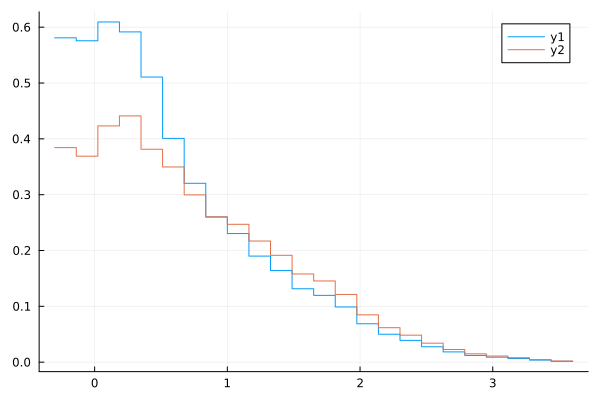

In [836]:
plot(loges25,
    [nulldists[30, 13, :] altedists[30, 13, :]],
    seriestype=:step
)

In [828]:
maximum(altedists)

0.3863905999445561

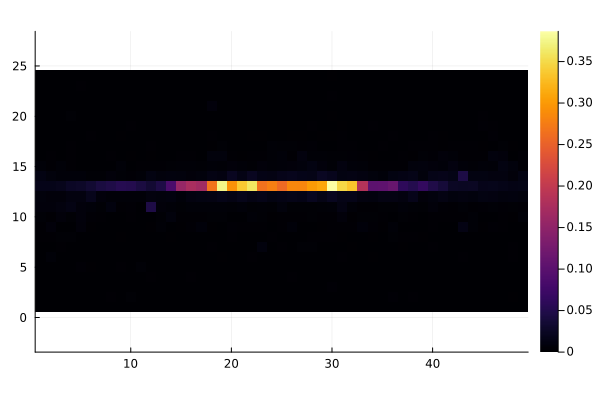

In [829]:
heatmap(altedists, aspect_ratio=1)

In [778]:
# diff = [(sum(nulldists[i, j, :]) - sum(altedists[i, j, :]))/sum(nulldists[i, j, :]) for i in 1:49, j in 1:24]

diff = zeros(49, 24)

for i in 1:49
    for j in 1:24
        diff[i, j] = (sum(nulldists[i, j, :]) - sum(altedists[i, j, :]))
    end
end

In [741]:
logdm2s = range(-15, -12, 10)

testtss = [asts(10^(logdm2s[i])) for i in 1:length(logdm2s)]

10-element Vector{Matrix{Float64}}:
 [-0.0 -0.0 … -0.0 -0.0; -0.0 -0.0 … 3.2788539106824027e-7 -0.0; … ; -0.0 6.068604719924875e-7 … -0.0 1.9280490458936476e-7; -0.0 7.749307824253537e-8 … -0.0 9.139681644843023e-8]
 [-0.0 -0.0 … -0.0 -0.0; -0.0 -0.0 … 5.4623967384072325e-6 -0.0; … ; -0.0 1.0134070501210957e-5 … -0.0 3.1985653283551387e-6; -0.0 1.275593480506293e-6 … -0.0 1.5258515744277779e-6]
 [-0.0 -0.0 … -0.0 -0.0; -0.0 -0.0 … 5.232174251808969e-5 -0.0; … ; -0.0 9.803070626856342e-5 … -0.0 3.0121976376211142e-5; -0.0 1.1665754928814887e-5 … -0.0 1.4744200815694497e-5]
 [-0.0 -0.0 … -0.0 -0.0; -0.0 -0.0 … 0.0002679117523220259 -0.0; … ; -0.0 0.0005178349463748136 … -0.0 0.0001469207162272414; -0.0 5.4057735658738504e-5 … -0.0 7.762259910708627e-5]
 [-0.0 -0.0 … -0.0 -0.0; -0.0 -0.0 … 0.000802310348883028 -0.0; … ; -0.0 0.0017127999580295247 … -0.0 0.00040554785297876143; -0.0 0.0002202066521885017 … -0.0 0.0002541154849922192]
 [-0.0 -0.0 … -0.0 -0.0; -0.0 -0.0 … 0.00120919721871413

In [744]:
tss = [sum(testtss[i]) for i in 1:10]

10-element Vector{Float64}:
  0.013525219627853524
  0.21063114308072983
  1.5894830906727848
  5.8874419922285295
 13.19298555304823
 20.098238508918755
 26.2637695029448
 32.83500880322173
 45.30406824110402
 58.26699696592482

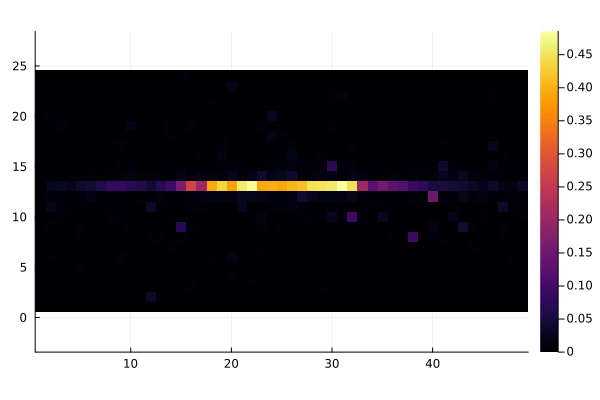

In [738]:
heatmap(testts, aspect_ratio=1)